## 필요한 데이터 불러오기 및 접근

## 필요한 라이브러리 설치

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/My Drive/nlp_liflow/

/content/drive/My Drive/nlp_liflow


In [3]:
!ls

자연어처리_1.ipynb		  스포츠_sen.csv
자연어처리_2.ipynb		  sentence_Summarizer.ipynb
all_df_with_tokens.csv		  textrank
all_sen.csv			  textrank_git
cc.ko.300.bin.gz		  자연어처리_tomotopy_HDPModel.ipynb
first_embedding_clustering.model  자연어처리_tomotopy.ipynb
ko.bin				  자연어처리_tomotopy_modeling.ipynb
nlp_tokenizer.ipynb		  word2vec_model


In [4]:
!curl -s https://raw.githubusercontent.com/teddylee777/machine-learning/master/99-Misc/01-Colab/mecab-colab.sh | bash

--2022-11-07 04:08:43--  https://www.dropbox.com/s/9xls0tgtf3edgns/mecab-0.996-ko-0.9.2.tar.gz?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.2.18, 2620:100:6017:18::a27d:212
Connecting to www.dropbox.com (www.dropbox.com)|162.125.2.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/dl/9xls0tgtf3edgns/mecab-0.996-ko-0.9.2.tar.gz [following]
--2022-11-07 04:08:44--  https://www.dropbox.com/s/dl/9xls0tgtf3edgns/mecab-0.996-ko-0.9.2.tar.gz
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucc258ca088144cc2ee1eff6189b.dl.dropboxusercontent.com/cd/0/get/BwSh1ZvYulN-2Xt9egGxXY4eqrsu5dPtOiGgV2V5cwqnL4HWwlhfEZ9ATKewl6C4XYsQeQb6sm1bFbKFKJScMTok_QZsa5LuUr8RgP0_QtBENDUrGsZ_4bVR7fmnZvrriRcrGVCEnTTOnf4oHtmtTOi0UTKKQSd_dFONuYpcFVYuRka5mRTPPf9kt2lLStnHKU0/file?dl=1# [following]
--2022-11-07 04:08:44--  https://ucc258ca088144cc2ee1eff6189b.dl.dropboxusercontent.com/cd/0/get/BwSh1ZvYulN-

In [5]:
!pip install kss

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 42.4 MB 1.7 MB/s 
     |████████████████████████████████| 131 kB 38.6 MB/s 
  Created wheel for kss: filename=kss-3.6.4-py3-none-any.whl size=42448613 sha256=2b08f50105eaa2084320059fef762bac16e31d4c55fa49511dfabf28cd78e3db
  Stored in directory: /root/.cache/pip/wheels/32/53/7c/76bdf098c2a6c5cd4c4c29648da30ad4793d604314b2aeb26f
Successfully built kss


In [6]:
import textrank_git
from textrank_git import rank
from textrank_git import sentence
from textrank_git import summarizer
from textrank_git import utils
from textrank_git import word
import re
import kss
import pandas as pd
from konlpy.tag import Mecab
import matplotlib.pyplot as plt
import urllib.request
from gensim.models.word2vec import Word2Vec
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from gensim import models
import gensim
import logging
import os
from collections import namedtuple, defaultdict
from collections.abc import Iterable
from timeit import default_timer
from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn.model_selection import train_test_split
from dataclasses import dataclass
from numpy import zeros, float32 as REAL, vstack, integer, dtype
import numpy as np
from gensim import utils, matutils  # utility fnc for pickling, common scipy operations etc
from gensim.utils import deprecated
from gensim.models import Word2Vec # noqa: F401
from gensim.models.keyedvectors import KeyedVectors
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score

In [7]:
mecab = Mecab()
def mecab_tokenize(sent):
  w = []
  a = re.compile('[^ ㄱ-ㅣ가-힣]+')
  words = mecab.pos(sent, join=True)
  word = [a.sub(r'',w) for w in words if ('/NNG' in w or '/NNP' in w or '/XR' in w or '/VV' in w or '/VA' in w)]

  for i in range(len(word)):
    if len(word[i])!=1:
      w.append(word[i])
  return w

'''
해당 함수는 추후에 사용될 키워드 추출, 키센텐스 추출에 필요한 토크나이저 함수입니다.
현재 /NNP, NNG, /XR , /VV, /VA 만을 추출하여 키워드/키센텐스를 추출하도록 짜여져 있습니다.
'''

'\n해당 함수는 추후에 사용될 키워드 추출, 키센텐스 추출에 필요한 토크나이저 함수입니다.\n현재 /NNP, NNG, /XR , /VV, /VA 만을 추출하여 키워드/키센텐스를 추출하도록 짜여져 있습니다.\n'

## 데이터 정리

###### 여기서 문장별로 나뉘어진 대화 셋을 한 대화로 합치고, 필요한 대화의 데이터의 카테고리를 재정의합니다.

In [8]:
files = pd.read_csv('all_df_with_tokens.csv', encoding ='utf-8', index_col = 0)
main_df = pd.DataFrame(columns = ['sentence', 'convrsThema'])
a = []
for i in range(len(files['convrsThema'])-1):
  if files['convrsThema'][i]==files['convrsThema'][i+1]:
    a.append(files['sentence'][i])

  else:
    a_str = " ".join(a)
    df = pd.DataFrame({'sentence' : a_str, 'convrsThema' : files['convrsThema'][i]}, index = [0])
    main_df = main_df.append(df, ignore_index = True)
    a = []
    
i = main_df[main_df['sentence']==""].index
main_df = main_df.drop(i)

main_df['convrsThema'] = main_df['convrsThema'].str.replace('코로나/생활', '투병')
main_df['convrsThema'] = main_df['convrsThema'].str.replace('메르스', '투병')
main_df['convrsThema'] = main_df['convrsThema'].str.replace('축구선수', '축구')
main_df['convrsThema'] = main_df['convrsThema'].str.replace(' 문학 ', '책')
main_df['convrsThema'] = main_df['convrsThema'].str.replace('독서', '책')
main_df['convrsThema'] = main_df['convrsThema'].str.replace('문학', '책')
main_df['convrsThema'] = main_df['convrsThema'].str.replace('집값', '부동산')
main_df['convrsThema'] = main_df['convrsThema'].str.replace('분양', '부동산')
main_df['convrsThema'] = main_df['convrsThema'].str.replace('직업', '직장')
main_df['convrsThema'] = main_df['convrsThema'].str.replace('일', '직장')
main_df['convrsThema'] = main_df['convrsThema'].str.replace('좋은글,사자성어,좋은글귀,등등 읽으면 도움이되는 글들..', '좋은글')
main_df['convrsThema'] = main_df['convrsThema'].str.replace('국제관계', '정치')
main_df['convrsThema'] = main_df['convrsThema'].str.replace('제테크', '재테크')
main_df['convrsThema'] = main_df['convrsThema'].str.replace('시사/재테크', '재테크')
main_df['convrsThema'] = main_df['convrsThema'].str.replace(' 경제/재테크 ', '재테크')
main_df['convrsThema'] = main_df['convrsThema'].str.replace(' 경제/재태크 ', '재테크')
main_df['convrsThema'] = main_df['convrsThema'].str.replace(' 자연/휴양지 ', '자연/여행')
main_df['convrsThema'] = main_df['convrsThema'].str.replace('자동차보험', '교통사고/보험')
main_df['convrsThema'] = main_df['convrsThema'].str.replace('교통사고', '교통사고/보험')
main_df['convrsThema'] = main_df['convrsThema'].str.replace('운전', '자동차')
main_df['convrsThema'] = main_df['convrsThema'].str.replace(' 자동차 ', '자동차')
main_df['convrsThema'] = main_df['convrsThema'].str.replace('자녀취업', '자녀')
main_df['convrsThema'] = main_df['convrsThema'].str.replace('자녀직장', '자녀')
main_df['convrsThema'] = main_df['convrsThema'].str.replace('자녀입대', '자녀')
main_df['convrsThema'] = main_df['convrsThema'].str.replace('자녀교육', '자녀')
main_df['convrsThema'] = main_df['convrsThema'].str.replace('자녀결혼', '자녀')
main_df['convrsThema'] = main_df['convrsThema'].str.replace('자녀 취업', '자녀')
main_df['convrsThema'] = main_df['convrsThema'].str.replace('자녀 교육', '자녀')
main_df['convrsThema'] = main_df['convrsThema'].str.replace('자녀 결혼', '자녀')
main_df['convrsThema'] = main_df['convrsThema'].str.replace('일상생활', '일상')
main_df['convrsThema'] = main_df['convrsThema'].str.replace('일상 이야기', '일상')
main_df['convrsThema'] = main_df['convrsThema'].str.replace('일상대화', '일상')
main_df['convrsThema'] = main_df['convrsThema'].str.replace('#일상', '일상')
main_df['convrsThema'] = main_df['convrsThema'].str.replace('이사', '이사/이민')
main_df['convrsThema'] = main_df['convrsThema'].str.replace('이민', '이사/이민')
main_df['convrsThema'] = main_df['convrsThema'].str.replace('먹거리', '음식')
main_df['convrsThema'] = main_df['convrsThema'].str.replace('먹거리/건강', '음식')
main_df['convrsThema'] = main_df['convrsThema'].str.replace(' 먹거리 ', '음식')
main_df['convrsThema'] = main_df['convrsThema'].str.replace('육아', '육아')
main_df['convrsThema'] = main_df['convrsThema'].str.replace('양육/교육', '육아')
main_df['convrsThema'] = main_df['convrsThema'].str.replace('교육', '교육')
main_df['convrsThema'] = main_df['convrsThema'].str.replace('운동', '스포츠')
main_df['convrsThema'] = main_df['convrsThema'].str.replace(' 스포츠/레저 ', '스포츠')
main_df['convrsThema'] = main_df['convrsThema'].str.replace('영화관', '영화관')
main_df['convrsThema'] = main_df['convrsThema'].str.replace(' 영화 ', '영화')
main_df['convrsThema'] = main_df['convrsThema'].str.replace('연예인', '방송/연예')
main_df['convrsThema'] = main_df['convrsThema'].str.replace(' 방송/연예 ', '방송/연예')
main_df['convrsThema'] = main_df['convrsThema'].str.replace(' 연애/결혼 ', '연애')
main_df['convrsThema'] = main_df['convrsThema'].str.replace('여행계획', '여행')
main_df['convrsThema'] = main_df['convrsThema'].str.replace('여가생활', '여가')
main_df['convrsThema'] = main_df['convrsThema'].str.replace('시댁살이', '시집살이')
main_df['convrsThema'] = main_df['convrsThema'].str.replace('시댁', '시집살이')
main_df['convrsThema'] = main_df['convrsThema'].str.replace('말씀나누기', '대화')
main_df['convrsThema'] = main_df['convrsThema'].str.replace(' 만화 ', '만화')
main_df['convrsThema'] = main_df['convrsThema'].str.replace('결혼생활', '결혼')
main_df['convrsThema'] = main_df['convrsThema'].str.replace('남편', '결혼')
main_df['convrsThema'] = main_df['convrsThema'].str.replace('건강/다이어트', '다이어트')
main_df['convrsThema'] = main_df['convrsThema'].str.replace(' 건강/다이어트 ', '다이어트')
main_df['convrsThema'] = main_df['convrsThema'].str.replace('노후준비', '노후')
main_df['convrsThema'] = main_df['convrsThema'].str.replace('노후대책', '노후')
main_df['convrsThema'] = main_df['convrsThema'].str.replace('넷플릭스', '방송')
main_df['convrsThema'] = main_df['convrsThema'].str.replace('TV', '방송')
main_df['convrsThema'] = main_df['convrsThema'].str.replace('드라마', '방송')
main_df['convrsThema'] = main_df['convrsThema'].str.replace(' 군대 ', '군대')
main_df['convrsThema'] = main_df['convrsThema'].str.replace('건강/교육', '건강')
main_df['convrsThema'] = main_df['convrsThema'].str.replace('가족건강', '건강')
main_df['convrsThema'] = main_df['convrsThema'].str.replace('가정', '가족')
main_df['convrsThema'] = main_df['convrsThema'].str.replace('#인생', '인생')
main_df['convrsThema'] = main_df['convrsThema'].str.replace('반려동물,강아지', '반려동물')
main_df['convrsThema'] = main_df['convrsThema'].str.replace(' 국가/지역 ', '국가/지역')
main_df['convrsThema'] = main_df['convrsThema'].str.replace(' 게임 ', '게임')
main_df['convrsThema'] = main_df['convrsThema'].str.replace('건강식', '건강식품')

main_df['convrsThema'] = main_df['convrsThema'].str.replace('수영', '스포츠')
main_df['convrsThema'] = main_df['convrsThema'].str.replace('볼링', '스포츠')
main_df['convrsThema'] = main_df['convrsThema'].str.replace('축구', '스포츠')
main_df['convrsThema'] = main_df['convrsThema'].str.replace('야구', '스포츠')
main_df['convrsThema'] = main_df['convrsThema'].str.replace('배구', '스포츠')
main_df['convrsThema'] = main_df['convrsThema'].str.replace('골프', '스포츠')
main_df['convrsThema'] = main_df['convrsThema'].str.replace('직장상', '직장')
main_df['convrsThema'] = main_df['convrsThema'].str.replace('#직장상', '직장')
main_df['convrsThema'] = main_df['convrsThema'].str.replace('직장화', '직장')
main_df['convrsThema'] = main_df['convrsThema'].str.replace('피시방', '게임')
main_df['convrsThema'] = main_df['convrsThema'].str.replace('요리', '음식')
main_df['convrsThema'] = main_df['convrsThema'].str.replace('밥', '음식')
main_df['convrsThema'] = main_df['convrsThema'].str.replace('건강식품품', '음식')
main_df['convrsThema'] = main_df['convrsThema'].str.replace('건강식품', '음식')
main_df['convrsThema'] = main_df['convrsThema'].str.replace('식습관', '음식')
main_df['convrsThema'] = main_df['convrsThema'].str.replace('음식점', '음식')
main_df['convrsThema'] = main_df['convrsThema'].str.replace('음식/건강', '음식')
main_df['convrsThema'] = main_df['convrsThema'].str.replace('영양제', '음식')
main_df['convrsThema'] = main_df['convrsThema'].str.replace('제주도', '여행')
main_df['convrsThema'] = main_df['convrsThema'].str.replace('휴양지', '여행')
main_df['convrsThema'] = main_df['convrsThema'].str.replace('등산', '취미생활')
main_df['convrsThema'] = main_df['convrsThema'].str.replace('캠핑', '취미생활')
main_df['convrsThema'] = main_df['convrsThema'].str.replace('여가', '취미생활')
main_df['convrsThema'] = main_df['convrsThema'].str.replace('게읻트볼', '취미생활')
main_df['convrsThema'] = main_df['convrsThema'].str.replace('자전거', '취미생활')
main_df['convrsThema'] = main_df['convrsThema'].str.replace('스쿠버다이빙', '취미생활')
main_df['convrsThema'] = main_df['convrsThema'].str.replace('해외여행', '여행')
main_df['convrsThema'] = main_df['convrsThema'].str.replace('건강검진', '건강')
main_df['convrsThema'] = main_df['convrsThema'].str.replace('연애/결혼', '연애')
main_df['convrsThema'] = main_df['convrsThema'].str.replace('육아', '자녀')
main_df['convrsThema'] = main_df['convrsThema'].str.replace('스포츠/레저', '스포츠')
main_df['convrsThema'] = main_df['convrsThema'].str.replace('재태크', '재테크')
main_df['convrsThema'] = main_df['convrsThema'].str.replace('부동산', '재테크')
main_df['convrsThema'] = main_df['convrsThema'].str.replace('경제', '재테크')
main_df['convrsThema'] = main_df['convrsThema'].str.replace('아파트', '재테크')
main_df['convrsThema'] = main_df['convrsThema'].str.replace('재개발', '재테크')
main_df['convrsThema'] = main_df['convrsThema'].str.replace('돈', '재테크')
main_df['convrsThema'] = main_df['convrsThema'].str.replace('경제/재테크', '재테크')
main_df['convrsThema'] = main_df['convrsThema'].str.replace('방송', '방송/연예')
main_df['convrsThema'] = main_df['convrsThema'].str.replace('영화', '방송/연예')
main_df['convrsThema'] = main_df['convrsThema'].str.replace('영화관', '방송/연예')
main_df['convrsThema'] = main_df['convrsThema'].str.replace('방송/연예/연예', '방송/연예')
main_df['convrsThema'] = main_df['convrsThema'].str.replace('책', '교육')
main_df['convrsThema'] = main_df['convrsThema'].str.replace('교통사고/보험/보험', '교통사고/보험')
main_df['convrsThema'] = main_df['convrsThema'].str.replace('자동차면허', '자동차')
main_df['convrsThema'] = main_df['convrsThema'].str.replace('벌초', '제사')
main_df['convrsThema'] = main_df['convrsThema'].str.replace('장례', '제사')
main_df['convrsThema'] = main_df['convrsThema'].str.replace('학창시절', '친구')
main_df['convrsThema'] = main_df['convrsThema'].str.replace('스포츠/레저', '스포츠')
main_df['convrsThema'] = main_df['convrsThema'].str.replace('여행/건강', '여행')
main_df['convrsThema'] = main_df['convrsThema'].str.replace('여행/자녀', '자녀')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: FutureWarning: The default value of regex will change from True to False in a future version.


In [9]:
main_df

sentence convrsThema
0      밥 한끼를 제대로 된 밥 한끼를 먹을 수 있다고 생각하면서 감사하게 감사하게 생각하...       방송/연예
1      그거 먹고 살아야 되는 거지 자식 물려줄 필요없고요 그걸로 모자라는 부분은 다른 곳...         재테크
2      결국 주차 요금을 올릴 수밖에 없어요 결국 최씨는 수리를 삼십일로 미뤄야 했습니다 ...         PBS
3      저 사람이 나한테 저렇게 행동을 하는구나 저 사람이 원하는 게 무엇인가를 내가 생각...        휴직장 
4      이 사람의 입장은 이럴 수 있구나 라고 배울 수 있는거지 그런건 정말 중요하고 꼭 ...         음식 
...                                                  ...         ...
13076  나는 궁금했던 사람이 별로 생각나지 않는데 예전에 도깨비 드라마 볼 때 한번 보고 ...       방송/연예
13078  나는 궁금했던 사람이 별로 생각나지 않는데 (SN:) 예전에 도깨비 드라마 볼 때 ...       방송/연예
13086      늘 사 먹게 되는데 그런 세태가 바뀌어야 할텐데 쉽지 않은 (SP:일이) 일이지요          음식
13087  세단 외에 우리가 차를 가지게 된 것이 (SP:놀) 놀러가려는 이유도 (NO:있었지...         자동차
13088  기술이 계속 발전하고 (SP:있으니) 있으니까 그런 식으로 새로운 기술을 접목시키게...         자동차

[10772 rows x 2 columns]

## 우선적으로 학습에 사용할 데이터 확보
###### 스포츠 데이터가 상당량 차지하고 있기 때문에 스포츠만 가지고 학습을 진행합니다.

In [10]:
main_df.value_counts(main_df['convrsThema'])

convrsThema
재테크       942
스포츠       917
방송/연예     731
자동차       715
여행        692
         ... 
직장 이야기      1
미래          1
반려동물        1
부산          1
직장반         1
Length: 84, dtype: int64

In [11]:
condition1 = (main_df['convrsThema'] == '스포츠')
thema = main_df.loc[condition1]
thema

sentence convrsThema
381    어제 탁구 시합할 때 빽 서브 연습을 안 하고 하니까  서브가 그게 잘 들어가던데 ...         스포츠
387    잘 안되더라 연습 하고 가야겠어 연습을 조금만 (SP:해가) 공이 허공으로 뜨고 그...         스포츠
393    어제 탁구 시합할 때 백 서브 연습을 안 하고 하니까  잘 안되더라 연습을 하고 가...         스포츠
400    (SP:이)제 탁구 시합을 (SP:택 팩)서브 연습을 (NO:안 하고 하니까 ) 어...         스포츠
406    (NO:)나도 유튜브를 본지 얼마 안됐는데  그래서 그만 둘까 하니까(SP: 사람들...         스포츠
...                                                  ...         ...
13012  근데 그렇게 멋있는 샷을 (NO:) 사라운드에서도 했어도 한번 무너지면 그래\r\n...         스포츠
13013  삼십분 매일 하는 것은 괜찮은데 (NO:너무 운동장만) 도는 것 말고도\r\n 요즘...         스포츠
13015  동네를 한바퀴 돌아도 되고 아빠트 단지를 한바퀴 돌아도 되고\r\n 그전에는 애들을...         스포츠
13017  스트레칭 시간이 이렇게 정해져 있기 때문에 (NO:) 십년 동안 하다보니까\r\n ...         스포츠
13065  나도 배드민턴 해봤지만 (NO:) 배드민턴 채 하나에 (SP:기) 기본적으로 최소 ...         스포츠

[917 rows x 2 columns]

## 데이터 전처리 
###### 데이터의 특수문자나 영어를 제외하고, kss를 사용해 문장을 재분류하는 과정을 거칩니다.

###### 이때 sents_all은 전처리 완료한 "스포츠"카테고리 대화 전체 데이터 셋을 말하며

###### sents는 학습에 sents_all 데이터 셋 중에서도 우선적으로 사용할 데이터 셋입니다.

In [12]:
#condition1 = (main_df['convrsThema'] == '스포츠')
#thema = main_df.loc[condition1]
import re
import kss
sents_all = []
k = []
for i in thema['sentence']:

  remain_pattern = re.compile(r'\([^)]*\)')
  hangul = re.compile('[^ ㄱ-ㅣ가-힣]+')

  ws_replace = re.sub(r'\xa0', r'', i)
  text_rm = remain_pattern.sub(r'', ws_replace)
  text = hangul.sub(r'', text_rm)
  k = kss.split_sentences(text)
  
  sents_all.append(k)
  k = []
sents_all ## sents_all은 "스포츠" 카테고리를 갖는 전체 대화 셋을 말합니다.

[['어제 탁구 시합할 때 빽 서브 연습을 안 하고 하니까 서브가 그게 잘 들어가던데 잘 안되더라 연습을 하고 가야겠어 연습을 조금만 하니까 공이 허공으로 뜨고 그러니까 상대방이 바로 때리니까 안 좋기는 안 좋더라고 가끔가다 한 번씩 때려주면 좋을 텐데 진짜 시합 할 때 빽 서브도 좋지만 화서브도 넣고 커트도 잘 되는데 커트가 잘 안될 때도 있잖 근데 빽 서브만 넣으면 안 되겠어 화서브 넣어도 상대방이 잘 알아서 때리니까 좀 그렇더라고 처음에 서브 넣으면 막 때리고 그러니까 한 번 때려 갖고 들어가면 기분이 안좋고 그날 진짜 플레이가 안 되더라고',
  '그런데 커트로 수비도 잘 하고 스매싱도 잘 하는데 단식보다 이제 복식 하면 뒤에서 스매싱으로 때려주면 되고 앞에서 수비 잘 하면 게임이 유리한 것 같은데 때리고 그러면 좀 실수가 많은 거 같지 않아 엊그제는 유튜브를 봤는데 유남규 선수 있잖아 유남규 선수가 설명을 잘해 주더라고 나도 유튜브를 본지 얼마 안됐는데 그게 도움이 많이 되는 거 같더라고 나도 가끔씩 보면 충분히 나도 할 수 있을 것 같은데 막상 게임 할 때는 잘 안 되더라고 맞아 그래서 연습을 많이 해야 할 것 같아 근데 나는 너무 안되서 레슨을 조금 받는데 하루에 십분 씩해서 일주일에 두 번 받거든',
  '확실히 받아보니까 조금 낫긴 하더라고',
  '근데 육만 원이야',
  '그게 확 티는 안나도 레슨 받은게 도움이 되고 오래 친 사람들도 계속 연습하면서 일 년에 한두 번씩 레슨을 받는다니까 그러니까 그렇게 잘 치는 거 같애',
  '잘 하는 분인데 내가 물어봤어 요즘에 많이 좋아졌더라고',
  '십분 정도 레슨을 받는데 잘하는 사람이랑 하니까 그 사람이 실수가 많이 줄었더라고',
  '그런데 또 잘 치는 사람들을 구경을 하는 것도 큰 도움이 되는 거 같애',
  '그지 나도 비슷하게라도 흉내를 낼라고 하면서 그것도 맞는 거 같어 내가상대방이 치는걸 보는데 내가 좀 해 볼라고 하면 잘 안 되고 좀 그렇더라 다른 사람이 치는건 잘 보이는데 내가 

In [13]:
thema.to_csv("스포츠_sen.csv") 
## 추후에 모델에 사용할 train 10개 문장을 고르기 위해 미리 csv 파일로 스포츠 대화 셋을 저장해 두었습니다.

## 원본 대화(스포츠)의 키워드 추출하기
key_textrank는 원문 키워드를 말하며

해당 과정은 textrank를 사용해 추출되었습니다.

이 작업은 추후에 doc2vec을 사용해 군집분석을 진행할 때 사용될 단어 리스트를 추리는 작업입니다.

In [14]:
for j in range(len(sents_all)):
  if len(sents_all[j])<=2:
    print(sents_all[j])

['여러가지 이 혈액순환이라든가 건강이 좋아 하다 보니까 나는 근력도 많이 좋아졌어 지금도 열심히 하는 중인 걸 모르지 다치는 경우도 많고 항상 내내가 도와줬어 해 보고 다 해 봤지만 요가가 더 좋은거 같아 워낙 좋아하다 보니까 일요일마다 갔어 한 번 보면 굉장히 느낌이 좋아 요가를하고 호흡법이 많이 좋아졌다고 생각해']
['나는 런닝머신을 한 삼십 분 정도 하는데 좋았어']
['서 무릎이 안 좋으신 분들 같은 경우는 자전거 타 나 좋다고 생각하거든요', '그러한 방식이']
['저는 이제 쉴 때에는 주로 운동을 해요']
['이제 제가 헬스하기 전에는 허리가 많이 안 좋아 허리 근력이 생기다 보니까 운동하는 게 너무 좋아']
['다들 바쁘겠지 바쁘겠지만 그래도 탁구가 좋아서 오는 사람들이 잖아 친구는 내가 이러게 같이 난타를 쳐 봤어', '진짜 이거는 진짜 반복해서 횟수가 문제인 것 같애 시간을 아무리 친다 해도 느는 게 속도가 반복돼 공 그렇게 쪼그만 게 사람들 갖고도 갖고 노는 거 보면 신기하다니까 나이 많이 먹어 갖고 남자들은 팔십도 넘더 라구']
['그런데 또 잘 치는 사람들을 구경을 하는 것도 큰 도움이 되는 거 같애', '그치 구 대회도 나가고 이제 잘 하다 보면 이제 시 대회도 나갈 수도 있잖아']
['스매싱 싱도 잘 되고 하는데 이제 저기 단식보다 복식을 하면 뒤에서 때려주고 근데 육만원이여 근데 받아보니까 조금 낫긴 낫더라고', '인제 나가기는 해도 어떨 때 속상할때가 많아 왜냐면 내가 너무 안 되니까']
['그게 그래서 그 회장님이 그 얘기 했자나']
['그게 잘 들어가던데 빽 서브 넣는게 카드도 잘 되고 하는데 카드가 조금 안될 때도 있잖아 스매싱도 잘 하고 그런데 카트로 수비도 잘해야지만 공 그런데 또 잘 치는 사람들을 구경을 하는 것도 큰 도움이 되는 것 같애', '그지 그게 나도 그렇게 할라고 비슷하게하더라도 흉내를 낼라고 하면서']
['이제 뭐 스쿼트나 런지 같은 거 요런 거 다 해서 다리가 좋아']
['좀 아플 때도 있고 약간 그럴 

In [15]:
import textrank_git
from textrank_git import rank
from textrank_git import sentence
from textrank_git import summarizer
from textrank_git import utils
from textrank_git import word

keyword_extractor = summarizer.KeywordSummarizer(
    tokenize = mecab_tokenize,
    window = -1,  
    min_count = 1,                                    
    verbose=False
)

key_textrank = []
key = []
a = []
k = []
for j in range(len(sents_all)):
  if len(sents_all[j])<=3:  # 대화가 2개 이하인 경우는 제외하고 대화 키워드 수집
    pass
  else:
    keywords = keyword_extractor.summarize(sents_all[j])
    for i in keywords:
      a.append(i[0])
    k.append(''.join(sents_all[j]))
    key_textrank.append(k)
    key.append(a)
    a = []
    k = []

key_textrank

[['어제 탁구 시합할 때 빽 서브 연습을 안 하고 하니까 서브가 그게 잘 들어가던데 잘 안되더라 연습을 하고 가야겠어 연습을 조금만 하니까 공이 허공으로 뜨고 그러니까 상대방이 바로 때리니까 안 좋기는 안 좋더라고 가끔가다 한 번씩 때려주면 좋을 텐데 진짜 시합 할 때 빽 서브도 좋지만 화서브도 넣고 커트도 잘 되는데 커트가 잘 안될 때도 있잖 근데 빽 서브만 넣으면 안 되겠어 화서브 넣어도 상대방이 잘 알아서 때리니까 좀 그렇더라고 처음에 서브 넣으면 막 때리고 그러니까 한 번 때려 갖고 들어가면 기분이 안좋고 그날 진짜 플레이가 안 되더라고그런데 커트로 수비도 잘 하고 스매싱도 잘 하는데 단식보다 이제 복식 하면 뒤에서 스매싱으로 때려주면 되고 앞에서 수비 잘 하면 게임이 유리한 것 같은데 때리고 그러면 좀 실수가 많은 거 같지 않아 엊그제는 유튜브를 봤는데 유남규 선수 있잖아 유남규 선수가 설명을 잘해 주더라고 나도 유튜브를 본지 얼마 안됐는데 그게 도움이 많이 되는 거 같더라고 나도 가끔씩 보면 충분히 나도 할 수 있을 것 같은데 막상 게임 할 때는 잘 안 되더라고 맞아 그래서 연습을 많이 해야 할 것 같아 근데 나는 너무 안되서 레슨을 조금 받는데 하루에 십분 씩해서 일주일에 두 번 받거든확실히 받아보니까 조금 낫긴 하더라고근데 육만 원이야그게 확 티는 안나도 레슨 받은게 도움이 되고 오래 친 사람들도 계속 연습하면서 일 년에 한두 번씩 레슨을 받는다니까 그러니까 그렇게 잘 치는 거 같애잘 하는 분인데 내가 물어봤어 요즘에 많이 좋아졌더라고십분 정도 레슨을 받는데 잘하는 사람이랑 하니까 그 사람이 실수가 많이 줄었더라고그런데 또 잘 치는 사람들을 구경을 하는 것도 큰 도움이 되는 거 같애그지 나도 비슷하게라도 흉내를 낼라고 하면서 그것도 맞는 거 같어 내가상대방이 치는걸 보는데 내가 좀 해 볼라고 하면 잘 안 되고 좀 그렇더라 다른 사람이 치는건 잘 보이는데 내가 칠 땐 잘 안되니까 어려워 생활 체육이지만 되게 탁구가 어려운거 같아 내가 배드민턴을 

## Doc2vec을 사용해 군집분석 실시

이 과정에서는 따로 tag(id)를 요약문으로 부여하지 않고 문서의 번호로만 나타냅니다. 

비슷한 대화가 어떤 것이 존재하느지에 대해서 알아보기 위한 과정입니다.

In [16]:
common_texts_and_tags = [
    (text, [f"convrs_{i}",]) for i, text in enumerate(key_textrank)
]

In [17]:
# common_text에는 파싱된 워드 리스트들이 들어가 있음.
#Doc2Vec이 우리가 텍스트를 사용해서 학습되는 모델(뉴럴넷)이고 
# TaggedDocument가 넘겨주는 텍스트들. TaggedDocument는 해당 corpus의 id를 함께 넘겨주는 것을 말합니다. 

#우리가 가진 데이터 전부 사용해 text와 tags 만들기
common_texts_and_tags = [
    (text, [f"convrs_{i}",]) for i, text in enumerate(key)
]

for text, tags in common_texts_and_tags:
    print(f"tags: {tags}, text: {text}")

TRAIN_documents = [TaggedDocument(words=text, tags=tags) for text, tags in common_texts_and_tags]
model = Doc2Vec(TRAIN_documents, vector_size=10, alpha = 0.025, epochs = 100, window=5, min_count=1, workers=4)

#모델 저장하기     
model.save('first_embedding_clustering.model')

doc_vec = pd.DataFrame(columns=['tag','text','trained_vector','convrs'])

# document의 vector를 구하는 방법은, 기 학습된 docvec을 가져오거나, 해당 단어를 넣고 다시 예측하는 것. 
for (text, tags),convrs in zip(common_texts_and_tags, key_textrank):
    trained_doc_vec = model.docvecs[tags[0]]
    test_doc_vec = model.infer_vector(text) #같은 문서를 모델에 다시 넣어서 옳게 임베딩을 진행했는지 확인해보기
    new_row = pd.DataFrame([[tags, text, trained_doc_vec, convrs]], columns = doc_vec.columns)
    doc_vec = pd.concat([doc_vec, new_row], ignore_index = True)
    print(f"tags: {tags}, text: {text}")
    print(f"trained_doc_vec: {trained_doc_vec}")
    print(f"inferred_doc_vec: {test_doc_vec}")
    print("--"*20)

tags: ['convrs_0'], text: ['사람', '탁구', '그러', '나가', '운동', '서브', '마음', '친구', '어렵', '나이', '연습', '때리', '스매싱', '실력', '생각', '모르', '해서', '그렇', '지미', '시골', '때려', '게임', '건강', '커트', '시간', '들어가', '상대방', '그래도', '배드민턴', '재밌']
tags: ['convrs_1'], text: ['사람', '탁구', '어렵', '시골', '실력', '탁구장', '친구', '생각', '나가', '마음', '그러', '모르', '회장', '지미', '게임', '그래도', '나이', '정도', '에이스', '이기', '힘들', '재밌', '공기', '다니', '스매싱', '운동', '기분', '만나', '서브', '가르쳐']
tags: ['convrs_2'], text: ['사람', '탁구', '에이스', '나가', '연습', '서브', '탁구장', '실력', '계단', '정도', '쳐서', '해서', '운동', '오르', '배드민턴', '게임', '때려', '레슨', '쉬운', '때릴', '다리', '그러', '스매싱', '어렵', '재밌', '보단', '자리', '재미', '날라가', '천장']
tags: ['convrs_3'], text: ['사람', '탁구', '그러', '어렵', '에이스', '실력', '나이', '지미', '나가', '회장', '친구', '운동', '서브', '해서', '그렇', '재미있', '탁구장', '이기', '위치', '약하', '스매싱', '커트', '연습', '생각', '배드민턴', '쉬운', '게임', '정도', '순발력', '재미']
tags: ['convrs_4'], text: ['탁구', '스매싱', '마음', '그러', '생각', '때리', '모르', '편하', '지미', '그래야', '반경', '배드민턴', '이제', '어울려서', '유튜브', '둘까', '얼마', '본지', '남자', 

In [18]:
doc_vec

tag                                               text  \
0      [convrs_0]  [사람, 탁구, 그러, 나가, 운동, 서브, 마음, 친구, 어렵, 나이, 연습, 때...   
1      [convrs_1]  [사람, 탁구, 어렵, 시골, 실력, 탁구장, 친구, 생각, 나가, 마음, 그러, ...   
2      [convrs_2]  [사람, 탁구, 에이스, 나가, 연습, 서브, 탁구장, 실력, 계단, 정도, 쳐서,...   
3      [convrs_3]  [사람, 탁구, 그러, 어렵, 에이스, 실력, 나이, 지미, 나가, 회장, 친구, ...   
4      [convrs_4]  [탁구, 스매싱, 마음, 그러, 생각, 때리, 모르, 편하, 지미, 그래야, 반경,...   
..            ...                                                ...   
477  [convrs_477]  [운동, 해야, 여유, 실천, 이제, 생활, 만약, 필요, 도와, 동안, 무릎, 보...   
478  [convrs_478]  [운동, 생각, 상대방, 생기, 보통, 거르, 하루, 바빠서, 개운, 사람, 해야,...   
479  [convrs_479]  [사람, 운동, 생각, 스포츠, 모르, 수영, 여유, 골프, 대해, 체육, 다리, ...   
480  [convrs_480]  [거리, 스트레스, 우승, 연습, 재미있, 즐기, 골프, 아빠, 옛날, 에이, 선수...   
481  [convrs_481]  [운동, 사람, 스트레칭, 꾸준, 근력, 자식, 나이, 건강, 혈압, 싸움, 해야,...   

                                        trained_vector  \
0    [-2.273296, -1.253364, 0.86211246, 1.0811528, ...   
1    [-2.2281585, -1.3237501, 1.34236, 0.6603625, 1...   
2    [-2.6653054, -0.98257256, 1.8463461, 1.9974319...   
3    [-2.5219874, -0.8620987, 1.6577638, 1.1715333,...   
4    [-2.367973, -0.7852063, 2.266786, 1.3847783, 1...   
..                                                 ...   
477  [-1.3243611, -0.16632192, -1.1027583, 2.866570...   
478  [-0.56415313, -0.11724842, 0.122561365, 2.7012...   
479  [0.19973435, 0.13939469, 0.44428036, -0.152500...   
480  [-1.7240506, -0.18512034, 1.9092537, -0.745040...   
481  [-0.47196284, -1.2245983, -0.5509694, 2.011844...   

                                                convrs  
0    [어제 탁구 시합할 때 빽 서브 연습을 안 하고 하니까 서브가 그게 잘 들어가던데 ...  
1    [잘 안되더라 연습 하고 가야겠어 연습을 조금만 공이 허공으로 뜨고 그러니까 근데 ...  
2    [어제 탁구 시합할 때 백 서브 연습을 안 하고 하니까 잘 안되더라 연습을 하고 가...  
3    [제 탁구 시합을 서브 연습을 어제 서브가 그게 잘 안 들어가는데 연습을 조금 하니...  
4    [나도 유튜브를 본지 얼마 안됐는데 그래서 그만 둘까 하니까그러더라고 그래야 또 잘...  
..                                                 ...  
477  [하여간 그냥 있는 것보다는 뭐라꼬 해야 해 골프를 치든 수영을 하든 나이 들면 병...  
478  [그리고 열일을 제쳐놓고 운동을 하러 가려고 여섯시만 그다음에는 헬스장을 가야 되는...  
479  [우리가 십년 전에 다리가 안 아플 때는 댄스 스포쯔가 한참 나왔잖아그것도 춤이지만...  
480  [근데 그렇게 멋있는 샷을 사라운드에서도 했어도 한번 무너지면 그래 맞아 김효주도 ...  
481  [삼십분 매일 하는 것은 괜찮은데 도는 것 말고도 요즘 운동장이나 공원 쪽에 가면 ...  

[482 rows x 4 columns]

## 군집화 진행해보기
시도해 볼 cluster 수는 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20 개 입니다.

### Elbow curve 
Cluster 간의 거리의 합을 나타내는 inertia가 급격히 떨어지는 구간이 생기는데 이 구간을 확인해 최적 군집 개수를 구하고자 합니다.


### silhouette score
군집 타당성 지표인 silhouette score를 사용해 적정 군집을 확인해 볼 예정입니다.

### Elbow curve


############################################################
K-Means Clustering
############################################################


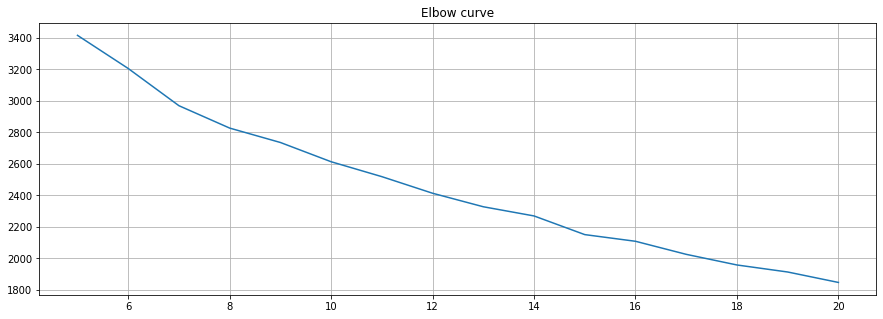

In [25]:
print("##"*30)
print("K-Means Clustering")
print("##"*30)
# 시도해 볼 cluster 수
cluster_number = range(5,21)
distortions = []

# 모델 학습
for k in cluster_number:
    Clustering_Method = KMeans(n_clusters=k, random_state = 0)
    X = model.docvecs.vectors_docs 
    Clustering_Method.fit(X)
    distortions.append(Clustering_Method.inertia_)
    
# Elbow Curve 시각화
fig = plt.figure(figsize=(15, 5))
plt.plot(cluster_number, distortions)
plt.grid(True)
plt.title('Elbow curve')
plt.show()

### silhouette


In [62]:
k_range = range(5, 21)

best_n = -1
best_silhouette_score = -1
X = model.docvecs.vectors_docs 
    
for k in k_range :
  Clustering_Method = KMeans(n_clusters=k, random_state = 0)
  Clustering_Method.fit(X)
  clusters = Clustering_Method.predict(X)

  score = silhouette_score(X, clusters)
  
  print('k: ',k, "score: ",score)

  if score > best_silhouette_score:
    best_n = k
    best_silhouette_score = score
print('best n : ', best_n, "best_score : ", best_silhouette_score)

k:  5 score:  0.15430877
k:  6 score:  0.1593714
k:  7 score:  0.17812783
k:  8 score:  0.18781824
k:  9 score:  0.17525722
k:  10 score:  0.17444855
k:  11 score:  0.18149091
k:  12 score:  0.18624862
k:  13 score:  0.18219574
k:  14 score:  0.19147418
k:  15 score:  0.19434601
k:  16 score:  0.1973002
k:  17 score:  0.20141582
k:  18 score:  0.21065685
k:  19 score:  0.2096425
k:  20 score:  0.22371748
best n :  20 best_score :  0.22371748


### hierarchical clustering

In [21]:
linkages = ['single', 'average','complete']

k_range = range(5, 20)
k_silhouette_df = pd.DataFrame(k_range, columns = ['k'])
X = model.docvecs.vectors_docs
for connect in linkages:
  k_silhouette = []
  
  for k in k_range:
    clustering = AgglomerativeClustering(n_clusters = k, linkage = connect)
    clusters = clustering.fit_predict(X)
    score = silhouette_score(X, clusters)

    result = [score]
    k_silhouette.append(result)
  score_df = pd.DataFrame(k_silhouette, columns = [connect + '_score'])
  k_silhouette_df = pd.concat([k_silhouette_df, score_df], axis=1)
k_silhouette_df

k  single_score  average_score  complete_score
0    5     -0.041934       0.141840        0.139277
1    6     -0.126471       0.122388        0.142721
2    7     -0.141024       0.132647        0.133689
3    8     -0.153541       0.140814        0.136352
4    9     -0.166548       0.151753        0.141618
5   10     -0.163813       0.159109        0.141760
6   11     -0.173163       0.149996        0.143626
7   12     -0.182303       0.144939        0.149374
8   13     -0.164437       0.149147        0.158486
9   14     -0.166823       0.150318        0.154186
10  15     -0.173305       0.152348        0.157852
11  16     -0.154604       0.149844        0.156242
12  17     -0.164400       0.160590        0.157255
13  18     -0.189006       0.170315        0.165716
14  19     -0.172574       0.165547        0.163044

### K_means 사용한 clustering 결과

In [29]:
Clustering_Method = KMeans(n_clusters=7, random_state=0)
X = model.docvecs.vectors_docs # document vector 전체를 가져옴. 
Clustering_Method.fit(X)# fitting 

cluster_dict = {i:[] for i in range(0, 7)}
for text, label in zip(doc_vec['convrs'], Clustering_Method.labels_):
    cluster_dict[label].append(text)
    cluster_dict[text].append()
    
for label, lst in cluster_dict.items():
    print(f"Cluster {label}")
    for x in lst:
        print(x)
    print("--"*30)
print("##"*20)

Cluster 0
['이동국이 운동하는 선수니까 우리나라에서는 또 뭐랄까 많이 알려진 공인이잖아그래서 그 사람이 그렇게 한 마디 했구만 나은이 이동국이가 나은이를 근데 요새 또 지금 코로나 때문에 도쿄 올림픽을 내년으로 연기를 해 버렸잖아엄마 생각에는 올림픽을 안 하면 우리나라 선수들이 여태 그걸 위해서 노력했잖아 이때까지 그 올림픽을 위해서 얼마나 많이 노력을 했고 또 거기에 걸려있는 게 많잖아이게 하나의 작은 스포츠가 아니라 정말 어마어마한 의미를 가지고 있다고 생각하거든걔들은 그 올림픽에서 그 성과를 내기 위해서 한 거지만 우리도 안 가겠다 했으면 좋겠어우리 안 간다고 뭐 하러 가냐고 이렇게 해서 일본에 강경하게 나가면 좋겠지만 어렵지 그 이면에는 감정적으로 부딪쳐서 얻을 게 별로 없을 거 같은 느낌이 들기도 하고 그래서 좀 어떻게 하는 게 좋을까 싶기도 해그리고 또 이런 생각도 들더라고혹시 이놈들이 우리나라 애들한테만 방사능 노출된 음식을 먹이지 않을까']
['먼젓번에 축구 축구 할 때 티비에 뭐였더라요번에 누구 축구선수 나왔잖아무슨 대회더라유 이십 맞아 유 이십 좀 젊은 친구들 나오는 대회 그 선수가 예전에 티비에 축구 가르치는 프로그램 거기에 나왔었더라고내가 그걸 옛날에 본 적이 있었거든걔가 쟤였구나 싶었지나도 축구를 많이 보진 않아 그런데 보니까 좀 남다르긴 다르더라 속도도 빠르고 축구에 굉장히 재능이 뛰어난 사람처럼 보이더라고 어렸을 때부터 그 노력한 결과인 것 같아 딱 옛날 걸 다시 봤거든 유튜브를 통해서 봤는데 진짜 어렸을 때부터 다르더라고혹시 알아 나도 언뜻 이름을 들었다고 그랬잖아 알고 보니까 내 지인의 아들이야그래서 한번 유심히 쳐다보긴 했어그런데 솔직히 관심은 없어 옛날에 안정환이 뛸 때 안정환 알지응 그때 당시에 많이 봤던 것 같은데 지금 세계적으로 유명한 호날두도 있겠지만 호날두 이번에 친선 경기 했잖아 한국에 와서 한국 프로 축구팀하고 한 경기 원래는 계약이 되어 있었대그런데 아무런 예고도 없이 안 나온 거야팬들은 기다렸는데 어리

In [61]:
#print(doc_vec[['trained_vector']])
for i in Clustering_Method.cluster_centers_:
  for j in doc_vec['trained_vector']:
    ㅁ

ValueError: ignored

In [30]:
Clustering_Method = KMeans(n_clusters=6, random_state=0)
X = model.docvecs.vectors_docs # document vector 전체를 가져옴. 
Clustering_Method.fit(X)# fitting 

cluster_dict = {i:[] for i in range(0, 6)}
for text, label in zip(doc_vec['convrs'], Clustering_Method.labels_):
    cluster_dict[label].append(text)
    

for label, lst in cluster_dict.items():
    print(f"Cluster {label}")
    for x in lst:
        print(x)
    print("--"*30)
print("##"*20)

Cluster 0
['우리 이따가 시간 내서 인터넷으로 검색도 해보고 찾아보자 도와주께 가격은 성인 오만 오천 원인가 하는데 그럼 이십 이일날 일찍 가서 줄 서자 그렇지 않아도 친구가 자꾸 필료하다고도 생각은 했지만 바쁘다는 핑계로 항상 일이 먼저라고 말했었어아직은 일에 집중해야 한다고 우리 애들이 다니는 건 한 이개월 됐거등내가 먼저 다니다가 같이 다닌 거야근데 육개월 이후에는 조금 그러더라고 그때는 더 힘든가 봐또 애만 혼자 보내기도 쪼끔 그렇더라고나도 해야 된다고 맨날 얘기했고 나도 마음먹은 지는 오래됐는데 어떤 운동을 어떻게 시작해야 될 지 내가 인터넷으로 검색해보고 괜찮은 거 있나 찾아서 오늘 저녁에 말해주께처음 시작할 때 나도 수영을 아예 못 했었거등근데 지금은 적응 다 했어 그럴 수도 있겠다나도 거기까지는 미처 생각을 못 했었는데 다행이네 접영이나 평영은 따라 가기가 어려워 보이는 것 같은데 꼭 배워야 하는 걸까 이것도 해 보까 저것도 해 볼까 그랬는데 수영장이 바로 근처여서 가게 됐어 이런 일이 있으므로 해서 건강도 더 다시 챙기게 되고 좋아진 것 같아 내 일상 생활이 너로 인해서 완전히 바뀐 것 같아 건강하게 살 게 되었어']
['나는 그냥 할만한 것 같아 내가 신경 써서 최대한 노력을 하려고 하지 주로 하는 운동은 걷기 정도 그런 의미에서 월요일에 같이 산행 갈까 사람들끼리 그냥 몇 명이라도 꼭 참석을 하고 운동하려고 노력하지 나도 그 생각은 해 우리가 걷기만 하니까 다리 운동이 안 되는 것 같아 요즘 두주 정도 쉬니까 근육량이 떨어지는 느낌이 드는 것 같더라고 주로 하는 운동은 그냥 걷기 정도 그런 의미에서 월요일에 같이 산행 갈까 월요 산행도 참석하려 하고 그런 산행 모임을 많이 하려고 하지 그게 한두주만 쉬어도 벌써 딱 틀린 것 같아 다리 힘 같은 게 말이야그래서 앞으로 조금 노력을 많이 하려고 해 운동 생각을 해 보긴 했지그런데 지금은 날도 너무 덥고 해서 조금 더 생각이 들면 하려고 아직은 그렇게 운동의 필요성이 와닿지 않아서 나중에

### 계층적 군집화 사용한 clustering 결과

## word2vec으로 임베딩 실시하기

사용된 단어묶음은 10개의 원문과 요약문에서 추출한 키워드를 말합니다.


In [ ]:
embedding_model = Word2Vec(key,  window = 10
                           , min_count=1, workers=4, iter = 100, sg=1)

In [ ]:
model_result = embedding_model.wv.most_similar("관절")
print(model_result)

#해당 과정은 "관절"과 유사한 단어를 뽑아보는 과정입니다.

## doc

## 문장별로 나뉘어진 리스트 한 문장으로 합치기

해당 과정은 한 대화가 문장별로 리스트에 담겨져 있기 때문에 여러 문장을 한 대화로 합쳐 다시 리스트에 넣는 과정입니다.

sent는 10개 추출 문장을 하나로 합친 결과, 
sents_all은 전체(스포츠) 대화의 문장을 하나로 합친 과정을 말합니다.

summ_sents는 요약문을 하나로 합친 결과를 말합니다.

In [29]:
q = []
for i in sents:
  a = " ".join(i)
  q.append(a)
sents = q

In [30]:
q = []
for i in sents_all:
  a = " ".join(i)
  q.append(a)
sents_all = q

In [31]:
q = []
for i in summ_sents:
  a = " ".join(i)
  q.append(a)
summ_sents = q

## 모델 저장하기

임베딩 모델을 구글 드라이브에 저장합니다.

In [32]:
embedding_model.save('word2vec_model') 

## 모델 불러오기

model이라는 변수에 기존에 저장한 embedding_model을 정의해 불러옵니다.

In [33]:
model = Word2Vec.load('/content/drive/MyDrive/nlp_liflow/word2vec_model')

# **🤖model 정의하기🤖**
### Doc2vec 모델을 정의합니다.

In [37]:
logger = logging.getLogger(__name__)

try:
    from gensim.models.doc2vec_inner import train_document_dbow, train_document_dm, train_document_dm_concat
except ImportError:
    raise utils.NO_CYTHON

try:
    from gensim.models.doc2vec_corpusfile import (
        d2v_train_epoch_dbow,
        d2v_train_epoch_dm_concat,
        d2v_train_epoch_dm,
        CORPUSFILE_VERSION
    )
except ImportError:
    # corpusfile doc2vec is not supported
    CORPUSFILE_VERSION = -1

    def d2v_train_epoch_dbow(model, corpus_file, offset, start_doctag, _cython_vocab, _cur_epoch, _expected_examples,
                             _expected_words, work, _neu1, docvecs_count, word_vectors=None, word_locks=None,
                             train_words=False, learn_doctags=True, learn_words=True, learn_hidden=True,
                             doctag_vectors=None, doctag_locks=None):
        raise NotImplementedError("Training with corpus_file argument is not supported.")

    def d2v_train_epoch_dm_concat(model, corpus_file, offset, start_doctag, _cython_vocab, _cur_epoch,
                                  _expected_examples, _expected_words, work, _neu1, docvecs_count, word_vectors=None,
                                  word_locks=None, learn_doctags=True, learn_words=True, learn_hidden=True,
                                  doctag_vectors=None, doctag_locks=None):
        raise NotImplementedError("Training with corpus_file argument is not supported.")

    def d2v_train_epoch_dm(model, corpus_file, offset, start_doctag, _cython_vocab, _cur_epoch, _expected_examples,
                           _expected_words, work, _neu1, docvecs_count, word_vectors=None, word_locks=None,
                           learn_doctags=True, learn_words=True, learn_hidden=True, doctag_vectors=None,
                           doctag_locks=None):
        raise NotImplementedError("Training with corpus_file argument is not supported.")


In [38]:
# TaggedDocument 클래스 : 단어와 태그로 구성된 단일 문서
class TaggedDocument(namedtuple('TaggedDocument', 'words tags')):
  def __str__(self):
       return '%s<%s, %s>' % (self.__class__.__name__, self.words, self.tags)

In [ ]:
class Doctag:
  __slots__ = ('doc_count', 'index', 'word_count')
  doc_count: int  # 태그가 나타난 문서 수
  index: int  # 기본 배열 위치
  word_count: int  # 연결된 문서의 단어 수

  @property
  def count(self):
      return self.doc_count  #문서 수를 반환한다

  @count.setter
  def count(self, new_val):
      self.doc_count = new_val #새로운 값을 doc_count에 넣는다

In [44]:
class Doc2Vec(Word2Vec):
  def __init__(self, documents=None, corpus_file=None, vector_size=100, dm_mean=None, dm=1, dbow_words=0, dm_concat=0,
            dm_tag_count=1, dv=None, dv_mapfile=None, comment=None, trim_rule=None, callbacks=(),
            window=5, epochs=10, shrink_windows=True, **kwargs,
        ):
    corpus_iterable = documents
'''
매개변수 목록
------------
### documents = gensim.models.doc2vec.태그가 지정된 문서 (선택사항)
### corpus_file = str (선택사항), 성능향상 위해서 documents 대신 courpus_file 사용 가능
### dm = {1, 0} training 알고리즘 정의(선택사항), 1이면 PV-DM, 0이면 PV-DBOW 사용됨
### vector_size = int, 형상벡터의 치수
### window = int, 문장 내에서 현재 단어와 예측 단어 사이의 최대 거리
### alpha = 초기 학습 속도
### min_alpha = float, 훈련이 진행됨에 따라 학습률은 선형적으로 min_alpha로 떨어진다
seed = int, 난수 생성기의 시드 
### min_count = int, 총 빈도가 이보다 낮은 모든 단어를 무시한다
max_vocab_size = int, 어휘 작성 중에 RAM을 제한한다. 1000만대의 단어 유형마다 약 1GB의 RAM 필요. 이 단어보다 더 사용하지 않는 단어는 잘라낸다
sample = float, 더 높은 빈도의 단어를 임의로 다운샘플링 하기 위한 임계값
workers = int, 멀티코어 머신으로 교육할 수 있음
### epochs = int, 말뭉치에 대한 반복 수
hs = {1,0} 1인경우 계층적 softmax가 사용 , 0으로 설정하고 0이 아닌 경우에는 음수 표본추출 사용
negative = int, 0을 초과하는 경우 음수에 대한 int는 "noise word" 수 지정 (5~20 사이)
ns_exponent = 음수 샘플링 분포를 형상화하는데 사용되는 지수 (1.0 표본의 값이 정확히 비례, 0은 모든 단어를 동일하게 샘플링, 음수는 저주파 단어를 더 많이 샘플링)
dm_mean = {1, 0} , 0이면 컨텍스트 단어 벡터의 합 사용, 1이면 평균 사용, dm이 비연결 모드에서 사용되는 경우만 사용
dm_concat = {1,0}, 1인경우 합/평균이 아닌 컨텍스트 벡터의 연결 사용(연결결과입력과 같이 훨씬 더 큰 모델이 됨), 
dm_tag_count = int, dm_concat 모드 사용시 문서 당 일정한 문서 태그 수 필요
dbow_words = {1,0}, 1로 설정된 경우 DB와 동시에 워드벡터를 학습함, 0인 경우에는 doc_vector만 학습함(더 빠름)
trim_rule = 특정 단어가 어휘에 남아있어야 하는지 여부를 지정한다. 


Attribute (객체)
-------------
wv = 단어와 임베딩 사이의 매핑을 포함, 학습 후 사용 가능 
dv = 훈련데이터에서 학습한 단락 벡터 포함되어 있음, 학습 중에 제공된 각 고유 문서 태그에 대해 태그를 사용해 개별적으로 액세스 가능
'''
    if dm_mean is not None:
        self.cbow_mean = dm_mean

    self.dbow_words = int(dbow_words)
    self.dm_concat = int(dm_concat)
    self.dm_tag_count = int(dm_tag_count)
    if dm and dm_concat:
        self.layer1_size = (dm_tag_count + (2 * window)) * vector_size
        logger.info("using concatenative %d-dimensional layer1", self.layer1_size)

    self.vector_size = vector_size
    self.dv = dv or KeyedVectors(self.vector_size, mapfile_path=dv_mapfile)
    self.dv.vectors_lockf = np.ones(1, dtype=REAL)  # 0.0 values suppress word-backprop-updates; 1.0 allows

    super(Doc2Vec, self).__init__(
            sentences=corpus_iterable,
            corpus_file=corpus_file,
            vector_size=self.vector_size,
            sg=(1 + dm) % 2,
            null_word=self.dm_concat,
            callbacks=callbacks,
            window=window,
            epochs=epochs,
            shrink_windows=shrink_windows,
            **kwargs,
        )
  def dm(self):
    return not self.sg

  def dbow(self):
    return self.sg

  def docvecs(self):
      return self.dv

  def docvecs(self, value):
      self.dv = value

  def _clear_post_train(self):
      self.wv.norms = None
      self.dv.norms = None

  def init_weights(self):
      super(Doc2Vec, self).init_weights()
      self.dv.resize_vectors(seed=self.seed + 7919)

  def reset_from(self, other_model):
      self.wv.key_to_index = other_model.wv.key_to_index
      self.wv.index_to_key = other_model.wv.index_to_key
      self.wv.expandos = other_model.wv.expandos
      self.cum_table = other_model.cum_table
      self.corpus_count = other_model.corpus_count
      self.dv.key_to_index = other_model.dv.key_to_index
      self.dv.index_to_key = other_model.dv.index_to_key
      self.dv.expandos = other_model.dv.expandos
      self.init_weights()

  def _do_train_epoch(self, corpus_file, thread_id, offset, cython_vocab, thread_private_mem, cur_epoch,
        total_examples=None, total_words=None, offsets=None, start_doctags=None, **kwargs):
      work, neu1 = thread_private_mem
      doctag_vectors = self.dv.vectors
      doctags_lockf = self.dv.vectors_lockf

      offset = offsets[thread_id]
      start_doctag = start_doctags[thread_id]

      if self.sg:
          examples, tally, raw_tally = d2v_train_epoch_dbow(
              self, corpus_file, offset, start_doctag, cython_vocab, cur_epoch,
              total_examples, total_words, work, neu1, len(self.dv),
              doctag_vectors=doctag_vectors, doctags_lockf=doctags_lockf, train_words=self.dbow_words)
      elif self.dm_concat:
          examples, tally, raw_tally = d2v_train_epoch_dm_concat(
              self, corpus_file, offset, start_doctag, cython_vocab, cur_epoch,
              total_examples, total_words, work, neu1, len(self.dv),
              doctag_vectors=doctag_vectors, doctags_lockf=doctags_lockf)
      else:
          examples, tally, raw_tally = d2v_train_epoch_dm(
              self, corpus_file, offset, start_doctag, cython_vocab, cur_epoch,
              total_examples, total_words, work, neu1, len(self.dv),
              doctag_vectors=doctag_vectors, doctags_lockf=doctags_lockf)

      return examples, tally, raw_tally

  def _do_train_job(self, job, alpha, inits):
      work, neu1 = inits
      tally = 0
      for doc in job:
          doctag_indexes = [self.dv.get_index(tag) for tag in doc.tags if tag in self.dv]
          doctag_vectors = self.dv.vectors
          doctags_lockf = self.dv.vectors_lockf
          if self.sg:
              tally += train_document_dbow(
                  self, doc.words, doctag_indexes, alpha, work, train_words=self.dbow_words,
                  doctag_vectors=doctag_vectors, doctags_lockf=doctags_lockf
                )
          elif self.dm_concat:
                tally += train_document_dm_concat(
                    self, doc.words, doctag_indexes, alpha, work, neu1,
                    doctag_vectors=doctag_vectors, doctags_lockf=doctags_lockf
                )
          else:
                tally += train_document_dm(
                    self, doc.words, doctag_indexes, alpha, work, neu1,
                    doctag_vectors=doctag_vectors, doctags_lockf=doctags_lockf
                )
      return tally, self._raw_word_count(job)
    
  def train(
        self, corpus_iterable=None, corpus_file=None, total_examples=None, total_words=None,
        epochs=None, start_alpha=None, end_alpha=None,
        word_count=0, queue_factor=2, report_delay=1.0, callbacks=(),
        **kwargs,
    ):
        if corpus_file is None and corpus_iterable is None:
            raise TypeError("Either one of corpus_file or corpus_iterable value must be provided")

        if corpus_file is not None and corpus_iterable is not None:
            raise TypeError("Both corpus_file and corpus_iterable must not be provided at the same time")

        if corpus_iterable is None and not os.path.isfile(corpus_file):
            raise TypeError("Parameter corpus_file must be a valid path to a file, got %r instead" % corpus_file)

        if corpus_iterable is not None and not isinstance(corpus_iterable, Iterable):
            raise TypeError("corpus_iterable must be an iterable of TaggedDocument, got %r instead" % corpus_iterable)

        if corpus_file is not None:
            # Calculate offsets for each worker along with initial doctags (doctag ~ document/line number in a file)
            offsets, start_doctags = self._get_offsets_and_start_doctags_for_corpusfile(corpus_file, self.workers)
            kwargs['offsets'] = offsets
            kwargs['start_doctags'] = start_doctags

        super(Doc2Vec, self).train(
            corpus_iterable=corpus_iterable, corpus_file=corpus_file,
            total_examples=total_examples, total_words=total_words,
            epochs=epochs, start_alpha=start_alpha, end_alpha=end_alpha, word_count=word_count,
            queue_factor=queue_factor, report_delay=report_delay, callbacks=callbacks, **kwargs)


  def _get_offsets_and_start_doctags_for_corpusfile(cls, corpus_file, workers):
        corpus_file_size = os.path.getsize(corpus_file)
        approx_offsets = [int(corpus_file_size // workers * i) for i in range(workers)]
        offsets = []
        start_doctags = []

        with utils.open(corpus_file, mode='rb') as fin:
            curr_offset_idx = 0
            prev_filepos = 0

            for line_no, line in enumerate(fin):
                if curr_offset_idx == len(approx_offsets):
                    break

                curr_filepos = prev_filepos + len(line)
                while curr_offset_idx != len(approx_offsets) and approx_offsets[curr_offset_idx] < curr_filepos:
                    offsets.append(prev_filepos)
                    start_doctags.append(line_no)

                    curr_offset_idx += 1

                prev_filepos = curr_filepos

        return offsets, start_doctags

  def _raw_word_count(self, job):
      return sum(len(sentence.words) for sentence in job)

  def estimated_lookup_memory(self):
      return 60 * len(self.dv) + 140 * len(self.dv)

  def infer_vector(self, doc_words, alpha=None, min_alpha=None, epochs=None):
        if isinstance(doc_words, str):  # a common mistake; fail with a nicer error
            raise TypeError("Parameter doc_words of infer_vector() must be a list of strings (not a single string).")

        alpha = alpha or self.alpha
        min_alpha = min_alpha or self.min_alpha
        epochs = epochs or self.epochs

        doctag_vectors = pseudorandom_weak_vector(self.dv.vector_size, seed_string=' '.join(doc_words))
        doctag_vectors = doctag_vectors.reshape(1, self.dv.vector_size)

        doctags_lockf = np.ones(1, dtype=REAL)
        doctag_indexes = [0]
        work = zeros(self.layer1_size, dtype=REAL)
        if not self.sg:
            neu1 = matutils.zeros_aligned(self.layer1_size, dtype=REAL)

        alpha_delta = (alpha - min_alpha) / max(epochs - 1, 1)

        for i in range(epochs):
            if self.sg:
                train_document_dbow(
                    self, doc_words, doctag_indexes, alpha, work,
                    learn_words=False, learn_hidden=False, doctag_vectors=doctag_vectors, doctags_lockf=doctags_lockf
                )
            elif self.dm_concat:
                train_document_dm_concat(
                    self, doc_words, doctag_indexes, alpha, work, neu1,
                    learn_words=False, learn_hidden=False, doctag_vectors=doctag_vectors, doctags_lockf=doctags_lockf
                )
            else:
                train_document_dm(
                    self, doc_words, doctag_indexes, alpha, work, neu1,
                    learn_words=False, learn_hidden=False, doctag_vectors=doctag_vectors, doctags_lockf=doctags_lockf
                )
            alpha -= alpha_delta

        return doctag_vectors[0]

  def __getitem__(self, tag):
        if isinstance(tag, (str, int, integer,)):
            if tag not in self.wv:
                return self.dv[tag]
            return self.wv[tag]
        return vstack([self[i] for i in tag])

  def __str__(self):
        segments = []
        if self.comment:
            segments.append('"%s"' % self.comment)
        if self.sg:
            if self.dbow_words:
                segments.append('dbow+w')  # also training words
            else:
                segments.append('dbow')  # PV-DBOW (skip-gram-style)

        else:  # PV-DM...
            if self.dm_concat:
                segments.append('dm/c')  # ...with concatenative context layer
            else:
                if self.cbow_mean:
                    segments.append('dm/m')
                else:
                    segments.append('dm/s')
        segments.append('d%d' % self.dv.vector_size)  # dimensions
        if self.negative:
            segments.append('n%d' % self.negative)  # negative samples
        if self.hs:
            segments.append('hs')
        if not self.sg or (self.sg and self.dbow_words):
            segments.append('w%d' % self.window)  # window size, when relevant
        if self.min_count > 1:
            segments.append('mc%d' % self.min_count)
        if self.sample > 0:
            segments.append('s%g' % self.sample)
        if self.workers > 1:
            segments.append('t%d' % self.workers)
        return '%s<%s>' % (self.__class__.__name__, ','.join(segments))

  def save_word2vec_format(self, fname, doctag_vec=False, word_vec=True, prefix='*dt_', fvocab=None, binary=False):
        total_vec = None
        # save word vectors
        if word_vec:
            if doctag_vec:
                total_vec = len(self.wv) + len(self.dv)
            self.wv.save_word2vec_format(fname, fvocab, binary, total_vec)
        # save document vectors
        if doctag_vec:
            write_header = True
            append = False
            if word_vec:
                # simply appending to existing file
                write_header = False
                append = True
            self.dv.save_word2vec_format(
                fname, prefix=prefix, fvocab=fvocab, binary=binary,
                write_header=write_header, append=append,
                sort_attr='doc_count')

  def init_sims(self, replace=False):
      self.dv.init_sims(replace=replace)
    
  def load(cls, *args, **kwargs):
      try:
            return super(Doc2Vec, cls).load(*args, rethrow=True, **kwargs)
      except AttributeError as ae:
            logger.error(
                "Model load error. Was model saved using code from an older Gensim version? "
                "Try loading older model using gensim-3.8.3, then re-saving, to restore "
                "compatibility with current code.")
            raise ae
  def estimate_memory(self, vocab_size=None, report=None):
        report = report or {}
        report['doctag_lookup'] = self.estimated_lookup_memory()
        report['doctag_syn0'] = len(self.dv) * self.vector_size * dtype(REAL).itemsize
        return super(Doc2Vec, self).estimate_memory(vocab_size, report=report)
  def build_vocab(
            self, corpus_iterable=None, corpus_file=None, update=False, progress_per=10000,
            keep_raw_vocab=False, trim_rule=None, **kwargs,
        ):
        total_words, corpus_count = self.scan_vocab(
            corpus_iterable=corpus_iterable, corpus_file=corpus_file,
            progress_per=progress_per, trim_rule=trim_rule,
        )
        self.corpus_count = corpus_count
        self.corpus_total_words = total_words
        report_values = self.prepare_vocab(update=update, keep_raw_vocab=keep_raw_vocab, trim_rule=trim_rule, **kwargs)

        report_values['memory'] = self.estimate_memory(vocab_size=report_values['num_retained_words'])
        self.prepare_weights(update=update)

  def build_vocab_from_freq(self, word_freq, keep_raw_vocab=False, corpus_count=None, trim_rule=None, update=False):
      logger.info("processing provided word frequencies")
      raw_vocab = word_freq
      logger.info(
            "collected %i different raw words, with total frequency of %i",
            len(raw_vocab), sum(raw_vocab.values()),
        )

        
      self.corpus_count = corpus_count or 0
      self.raw_vocab = raw_vocab

        
      report_values = self.prepare_vocab(keep_raw_vocab=keep_raw_vocab, trim_rule=trim_rule, update=update)
      report_values['memory'] = self.estimate_memory(vocab_size=report_values['num_retained_words'])
      self.prepare_weights(update=update)

  def _scan_vocab(self, corpus_iterable, progress_per, trim_rule):
        document_no = -1
        total_words = 0
        min_reduce = 1
        interval_start = default_timer() - 0.00001  # guard against next sample being identical
        interval_count = 0
        checked_string_types = 0
        vocab = defaultdict(int)
        max_rawint = -1  # highest raw int tag seen (-1 for none)
        doctags_lookup = {}
        doctags_list = []
        for document_no, document in enumerate(corpus_iterable):
            if not checked_string_types:
                if isinstance(document.words, str):
                    logger.warning(
                        "Each 'words' should be a list of words (usually unicode strings). "
                        "First 'words' here is instead plain %s.",
                        type(document.words),
                    )
                checked_string_types += 1
            if document_no % progress_per == 0:
                interval_rate = (total_words - interval_count) / (default_timer() - interval_start)
                logger.info(
                    "PROGRESS: at example #%i, processed %i words (%i words/s), %i word types, %i tags",
                    document_no, total_words, interval_rate, len(vocab), len(doctags_list)
                )
                interval_start = default_timer()
                interval_count = total_words
            document_length = len(document.words)

            for tag in document.tags:
                # Note a document tag during initial corpus scan, for structure sizing.
                if isinstance(tag, (int, integer,)):
                    max_rawint = max(max_rawint, tag)
                else:
                    if tag in doctags_lookup:
                        doctags_lookup[tag].doc_count += 1
                        doctags_lookup[tag].word_count += document_length
                    else:
                        doctags_lookup[tag] = Doctag(index=len(doctags_list), word_count=document_length, doc_count=1)
                        doctags_list.append(tag)

            for word in document.words:
                vocab[word] += 1
            total_words += len(document.words)

            if self.max_vocab_size and len(vocab) > self.max_vocab_size:
                utils.prune_vocab(vocab, min_reduce, trim_rule=trim_rule)
                min_reduce += 1

        corpus_count = document_no + 1
        if len(doctags_list) > corpus_count:
            logger.warning("More unique tags (%i) than documents (%i).", len(doctags_list), corpus_count)
        if max_rawint > corpus_count:
            logger.warning(
                "Highest int doctag (%i) larger than count of documents (%i). This means "
                "at least %i excess, unused slots (%i bytes) will be allocated for vectors.",
                max_rawint, corpus_count, max_rawint - corpus_count,
                (max_rawint - corpus_count) * self.vector_size * dtype(REAL).itemsize,
            )
        if max_rawint > -1:
            # adjust indexes/list to account for range of pure-int keyed doctags
            for key in doctags_list:
                doctags_lookup[key].index = doctags_lookup[key].index + max_rawint + 1
            doctags_list = list(range(0, max_rawint + 1)) + doctags_list

        self.dv.index_to_key = doctags_list
        for t, dt in doctags_lookup.items():
            self.dv.key_to_index[t] = dt.index
            self.dv.set_vecattr(t, 'word_count', dt.word_count)
            self.dv.set_vecattr(t, 'doc_count', dt.doc_count)
        self.raw_vocab = vocab
        return total_words, corpus_count

  def scan_vocab(self, corpus_iterable=None, corpus_file=None, progress_per=100000, trim_rule=None):
        logger.info("collecting all words and their counts")
        if corpus_file is not None:
            corpus_iterable = TaggedLineDocument(corpus_file)

        total_words, corpus_count = self._scan_vocab(corpus_iterable, progress_per, trim_rule)

        logger.info(
            "collected %i word types and %i unique tags from a corpus of %i examples and %i words",
            len(self.raw_vocab), len(self.dv), corpus_count, total_words,
        )

        return total_words, corpus_count

  def similarity_unseen_docs(self, doc_words1, doc_words2, alpha=None, min_alpha=None, epochs=None):
        d1 = self.infer_vector(doc_words=doc_words1, alpha=alpha, min_alpha=min_alpha, epochs=epochs)
        d2 = self.infer_vector(doc_words=doc_words2, alpha=alpha, min_alpha=min_alpha, epochs=epochs)
        return np.dot(matutils.unitvec(d1), matutils.unitvec(d2))

In [45]:
class Doc2VecVocab(utils.SaveLoad):
   """Obsolete class retained for now as load-compatibility state capture"""
class Doc2VecTrainables(utils.SaveLoad):
  """Obsolete class retained for now as load-compatibility state capture"""

In [46]:
class TaggedBrownCorpus:
  def __init__(self, dirname):
    self.dirname = dirname

  def __iter__(self):
      for fname in os.listdir(self.dirname):
          fname = os.path.join(self.dirname, fname)
          if not os.path.isfile(fname):
              continue
          with utils.open(fname, 'rb') as fin:
              for item_no, line in enumerate(fin):
                  line = utils.to_unicode(line)
                  token_tags = [t.split('/') for t in line.split() if len(t.split('/')) == 2]
                  words = ["%s/%s" % (token.lower(), tag[:2]) for token, tag in token_tags if tag[:2].isalpha()]
                  if not words:  
                      continue
                  yield TaggedDocument(words, ['%s_SENT_%s' % (fname, item_no)])


In [47]:
class TaggedLineDocument:
  def __init__(self, source):
    self.source = source
  def __iter__(self):
        try:
            self.source.seek(0)
            for item_no, line in enumerate(self.source):
                yield TaggedDocument(utils.to_unicode(line).split(), [item_no])
        except AttributeError:
            with utils.open(self.source, 'rb') as fin:
                for item_no, line in enumerate(fin):
                    yield TaggedDocument(utils.to_unicode(line).split(), [item_no])

## 핵심 문장 추출해보기

##### NB 모델 학습을 진행하기 앞서 textrank를 사용해 핵심문장 추출을 진행해보았습니다.

###### 이 과정은 추후에 옳게 분류된 요약문과 핵심 문장을 한번에 볼 수 있게 해줍니다.

###### 또한 추출된 핵심문장만을 학습 데이터로 사용할 수도 있습니다.

In [16]:
summarizer = summarizer.KeysentenceSummarizer(tokenize = mecab_tokenize, min_sim = 0.7)
keysents = summarizer.summarize(sents[0], topk=5)
keysents  # 첫번째 대화문의 핵심 문장을 총 5개 뽑도록 짜여져 있습니다.

[(14,
  1.2440295340390812,
  '아 힘든 건 있어 있는데 또 시골에 가면 공기가 맑잖아 한 번 들에 나가서 할라고 하면 배드민턴을 한 이십 년 쳤고 탁구를 쳐봤는데 그대로 칠 수도 있고 안 칠 수도 있잖아 탁구장에서 사람들이 서브할 때 때릴 때 공이 날라 가잖아 하는 것보다 게임이라는게 이길 수도 있고 질 수도 있고 해서 재밌게 치려고 해 나는 에이스들이 치는 데 보다 그 밑에서 치는 게 더 좋아 공을 잘못 때려 가지고 어떤 때는 천장을 맞을 때도 있어 생각없이 친 공이 날라가니까 그런 재미로 나는 치는거 같아 그래서 나는 에이스 자리 가서 치는것 보단 밑에서 치는게 좋더라고 쉬운데서 쳐서 그런지 탁구가 안느는 것 같아 그 밑에 코트에서 치면 마음 놓고 치다보니까 거기가 더 좋지 하여튼 나는 못 치더라도 탁구장에 갈 때는 기분은 좋더라고'),
 (20, 1.0, '팔십 넘은 사람도 있더라구 나이 먹어서는 라지 볼 이라해서 빨간공이 있는데'),
 (11, 1.0, '그리고 잘 할지 못 할지 몰라도 한 번 생각해 볼게 젊은 사람들이 탁구치는 거 보면 잘하는데 난 자신이 없네'),
 (1,
  1.0,
  '가끔가다 한번씩 때려주면 좋을 텐데 진짜 시합 할 때 백 서브도 좋지만 화 서브도 넣고 커트도 잘 되는데 커트가 잘 안될 때도 있잖아'),
 (5,
  1.0,
  '그게 확 티는 안 나도 레슨 받은 게 도움이 되고 오래 친 사람들도 계속 연습하면서 일년에 한 두번씩 레슨을 받는다니까 그러니까 그렇게 잘 치는 거 같아 레슨 받는 데 보니까 그 사람이 때릴 때 실수를 좀 하더라고')]